# <center>**Partially Coded FOV**<center>

**Libraries**

In [1]:
import numpy as np
from scipy.signal import correlate

np.set_printoptions(precision=2, suppress=False)

## **2D URA/MURA Masks with PCFOV**

### **1D URA Mask Pattern with PCFOV**

In [2]:
ura_pattern = np.array([1, 1, 1, 0, 1, 0, 0])

In [4]:
cut = (len(ura_pattern) - 1)//2
ura_mask = np.concatenate((ura_pattern[-cut:], ura_pattern, ura_pattern[:cut]))
ura_decoder = (2*ura_mask - 1)/ura_pattern.sum()

print(f"mask pattern: {ura_mask}\n"
      f"decoder pattern: {ura_decoder}")

mask pattern: [1 0 0 1 1 1 0 1 0 0 1 1 1]
decoder pattern: [ 0.25 -0.25 -0.25  0.25  0.25  0.25 -0.25  0.25 -0.25 -0.25  0.25  0.25
  0.25]


In [13]:
sky_image = np.array([0, 0, 0, 1, 0, 0, 0])
detector_image = correlate(ura_mask, sky_image, mode='valid')
sky_reconstruction = correlate(ura_decoder, detector_image, mode='valid')

print(f"detector image: {detector_image}\n"
      f"sky reconstruction image: {sky_reconstruction}")

detector image: [1 1 1 0 1 0 0]
sky reconstruction image: [0. 0. 0. 1. 0. 0. 0.]


- By adding the PCFOV, we pad with zeros the mask (in `mode='valid'`) to reproduce the full slicing of the sky image on the mask
- This should be the same of the correlation in `mode='full'` since we take the full correlation output of length $3m - 2$ if $m = k$ (sky image shape $=$ basic pattern shape)

In [14]:
pcfov_zeropad = np.zeros(len(ura_pattern) - 1)
pcfov_ura_mask = np.concatenate((pcfov_zeropad, ura_mask, pcfov_zeropad))
pcfov_ura_decoder = np.concatenate((pcfov_zeropad, ura_decoder, pcfov_zeropad))

print(f"PCFOV mask pattern: {pcfov_ura_mask}\n"
      f"PCFOV decoder pattern: {pcfov_ura_decoder}\n"
      f"length of the mask: {len(pcfov_ura_mask)}")

PCFOV mask pattern: [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0.]
PCFOV decoder pattern: [ 0.    0.    0.    0.    0.    0.    0.25 -0.25 -0.25  0.25  0.25  0.25
 -0.25  0.25 -0.25 -0.25  0.25  0.25  0.25  0.    0.    0.    0.    0.
  0.  ]
length of the mask: 25


In [15]:
pcfov_detector_image = correlate(pcfov_ura_mask, sky_image, mode='valid')
pcfov_sky_reconstruction = correlate(pcfov_ura_decoder, pcfov_detector_image, mode='valid')

print(f"detector image: {pcfov_detector_image}\n"
      f"sky reconstruction image: {pcfov_sky_reconstruction}\n"
      f"length of the detector: {len(pcfov_detector_image)}\n"
      f"length of the sky reconstruction: {len(pcfov_sky_reconstruction)}\n"
      f"length of the detector = 3m - 2: {len(pcfov_detector_image) == 3*len(ura_pattern) - 2}")

detector image: [0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
sky reconstruction image: [-0.25 -0.25  0.25  2.    0.25  0.    0.25]
length of the detector: 19
length of the sky reconstruction: 7
length of the detector = 3m - 2: True


- By performing the PSF in the PCFOV modality we should see a delta in the central zone plus noisy edges

In [16]:
pcfov_psf = correlate(pcfov_ura_decoder, ura_pattern, mode='valid')

print(f"PSF: {pcfov_psf}\n"
      f"length of the PSF: {len(pcfov_psf)}\n"
      f"central PSF: {pcfov_psf[len(pcfov_zeropad) : -len(pcfov_zeropad)]}\n"
      f"length of the central PSF: {len(pcfov_psf[len(pcfov_zeropad) : -len(pcfov_zeropad)])}")

PSF: [ 0.    0.    0.25 -0.25  0.    0.25  0.    0.    0.    1.    0.    0.
  0.    0.    0.    0.25  0.75  0.5   0.25]
length of the PSF: 19
central PSF: [0. 0. 0. 1. 0. 0. 0.]
length of the central PSF: 7


- If we now use the full correlation

In [17]:
full_psf = correlate(ura_decoder, ura_pattern, mode='full')

print(f"PSF: {full_psf}\n"
      f"length of the PSF: {len(full_psf)}\n"
      f"central PSF: {full_psf[len(pcfov_zeropad) : -len(pcfov_zeropad)]}\n"
      f"length of the central PSF: {len(full_psf[len(pcfov_zeropad) : -len(pcfov_zeropad)])}\n")

print(f"full_psf = pcfov_psf: {np.all(full_psf == pcfov_psf)}")

PSF: [ 0.    0.    0.25 -0.25  0.    0.25  0.    0.    0.    1.    0.    0.
  0.    0.    0.    0.25  0.75  0.5   0.25]
length of the PSF: 19
central PSF: [0. 0. 0. 1. 0. 0. 0.]
length of the central PSF: 7

full_psf = pcfov_psf: True


In [18]:
full_detector_image = correlate(ura_mask, sky_image, mode='full')
central_full_detector_image = full_detector_image[len(pcfov_zeropad) : -len(pcfov_zeropad)]

full_sky_reconstruction = correlate(ura_decoder, central_full_detector_image, mode='full')
central_full_sky_reconstruction = full_sky_reconstruction[len(pcfov_zeropad) : -len(pcfov_zeropad)]

print(f"full detector image: {full_detector_image}\n"
      f"central full detector image: {central_full_detector_image}\n"
      f"sky reconstruction image: {full_sky_reconstruction}\n"
      f"central sky reconstruction image: {central_full_sky_reconstruction}\n"
      f"length of the detector: {len(full_detector_image)}\n"
      f"length of the central detector: {len(central_full_detector_image)}\n"
      f"length of the sky reconstruction: {len(full_sky_reconstruction)}\n"
      f"length of the central sky reconstruction: {len(central_full_sky_reconstruction)}\n")

print(f"length of the detector = 3m - 2: {len(full_detector_image) == 3*len(ura_pattern) - 2}\n"
      f"full_detector_image = pcfov_detector_image: {np.all(full_detector_image == pcfov_detector_image)}\n"
      f"central_full_sky_reconstruction = sky_image: {np.all(central_full_sky_reconstruction == sky_image)}")

full detector image: [0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0]
central full detector image: [1 1 1 0 1 0 0]
sky reconstruction image: [ 0.    0.    0.25 -0.25  0.    0.25  0.    0.    0.    1.    0.    0.
  0.    0.    0.    0.25  0.75  0.5   0.25]
central sky reconstruction image: [0. 0. 0. 1. 0. 0. 0.]
length of the detector: 19
length of the central detector: 7
length of the sky reconstruction: 19
length of the central sky reconstruction: 7

length of the detector = 3m - 2: True
full_detector_image = pcfov_detector_image: True
central_full_sky_reconstruction = sky_image: True


- In the full mode we have to consider only the central part of the image (between `n - 1` and `-n + 1` with `n = len(ura_pattern)`)

In [20]:
full_detector_image = correlate(ura_mask, sky_image, mode='full')
central_full_detector_image = full_detector_image[len(pcfov_zeropad) : -len(pcfov_zeropad)]

full_sky_reconstruction = correlate(ura_decoder, full_detector_image, mode='full')
central_full_sky_reconstruction = full_sky_reconstruction[2*len(pcfov_zeropad) : -2*len(pcfov_zeropad)]

print(f"full detector image: {full_detector_image}\n"
      f"central full detector image: {central_full_detector_image}\n"
      f"sky reconstruction image: {full_sky_reconstruction}\n"
      f"central sky reconstruction image: {central_full_sky_reconstruction}\n"
      f"length of the detector: {len(full_detector_image)}\n"
      f"length of the central detector: {len(central_full_detector_image)}\n"
      f"length of the sky reconstruction: {len(full_sky_reconstruction)}\n"
      f"length of the central sky reconstruction: {len(central_full_sky_reconstruction)}\n")

print(f"length of the detector = 3m - 2: {len(full_detector_image) == 3*len(ura_pattern) - 2}\n"
      f"full_detector_image = pcfov_detector_image: {np.all(full_detector_image == pcfov_detector_image)}\n"
      f"central_full_sky_reconstruction = sky_image: {np.all(central_full_sky_reconstruction == sky_image)}\n"
      f"""central_full_sky_reconstruction = central_full_sky_reconstruction cell above: {
          np.all(central_full_sky_reconstruction == correlate(ura_decoder, central_full_detector_image, mode='full')[len(pcfov_zeropad) : -len(pcfov_zeropad)])
      }""")

full detector image: [0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0]
central full detector image: [1 1 1 0 1 0 0]
sky reconstruction image: [ 0.    0.    0.    0.25  0.   -0.25 -0.25  0.25  1.    0.    0.25  0.
 -0.25 -0.25  0.25  2.    0.25  0.    0.25  0.25  0.25  0.    1.    0.25
  0.    0.25  0.25  0.25  0.    0.    0.  ]
central sky reconstruction image: [-0.25 -0.25  0.25  2.    0.25  0.    0.25]
length of the detector: 19
length of the central detector: 7
length of the sky reconstruction: 31
length of the central sky reconstruction: 7

length of the detector = 3m - 2: True
full_detector_image = pcfov_detector_image: True
central_full_sky_reconstruction = sky_image: False
central_full_sky_reconstruction = central_full_sky_reconstruction cell above: False


- Let's try padding the sky image in the valid mode and how it's related to the full mode

In [6]:
sky_image = np.array([0, 0, 0, 1, 0, 0, 0])
pcfov_zeropad = np.zeros(len(ura_pattern) - 1)
pcfov_sky_image = np.concatenate((pcfov_zeropad, sky_image, pcfov_zeropad))

detector_image = correlate(ura_mask, pcfov_sky_image, mode='valid')
sky_reconstruction = correlate(ura_decoder, detector_image, mode='valid')

print(f"detector image: {detector_image}\n"
      f"sky reconstruction image: {sky_reconstruction}")

detector image: [1. 1. 1. 0. 1. 0. 0.]
sky reconstruction image: [0. 0. 0. 1. 0. 0. 0.]


<br>

### **2D URA Mask Pattern with PCFOV**

In [2]:
import maskpattern as mp
import plot_module as plot

In [60]:
import importlib
importlib.reload(plot)

<module 'plot_module' from '/home/starfloyd/PhD_Coding/MasksReconstructionTest/Img_ReconstructionMethods_2D/plot_module.py'>

In [3]:
ura = mp.URAMaskPattern(5)
ura_pattern2D, ura_decoder2D = ura.basic_pattern, ura.basic_decoder

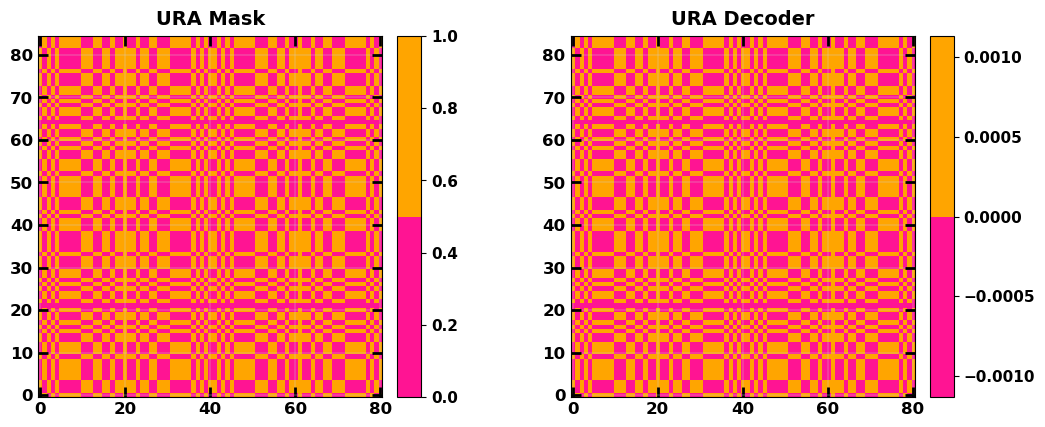

In [4]:
n, m = ura_pattern2D.shape
pad_n, pad_m = (n - 1)//2, (m - 1)//2

mask = np.pad(ura_pattern2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')
decoder = np.pad(ura_decoder2D, pad_width=((pad_n, pad_n), (pad_m, pad_m)), mode='wrap')

plot.image_plot([mask, decoder],
                ["URA Mask", "URA Decoder"])


In [5]:
import collections.abc as c

def sky_image_simulation(sky_image_shape: tuple[int, int],
                         sources_flux: c.Sequence[int],
                         sources_pos: None | c.Sequence[tuple[int, int]] = None,
                         sky_background_rate: None | int = None,
                         ) -> tuple[c.Sequence, None | c.Sequence]:
    """Simulates the sky image given the sources flux."""

    sky_image = np.zeros(sky_image_shape)

    if sources_pos is None:
        sources_pos = [(np.random.randint(0, sky_image_shape[0]), np.random.randint(0, sky_image_shape[1]))
                       for _ in range(len(sources_flux))]

    # assign fluxes to point-like sources
    for i, pos in enumerate(sources_pos):
        sky_image[pos[0], pos[1]] = sources_flux[i]

    # add sky background
    if sky_background_rate is not None:
        sky_background = np.random.poisson(sky_background_rate, sky_image_shape)
        sky_image += sky_background
    else:
        sky_background = None
    
    return sky_image, sky_background, sources_pos

- Let's start by padding the sky image (in valid mode) and then compute the full correlation

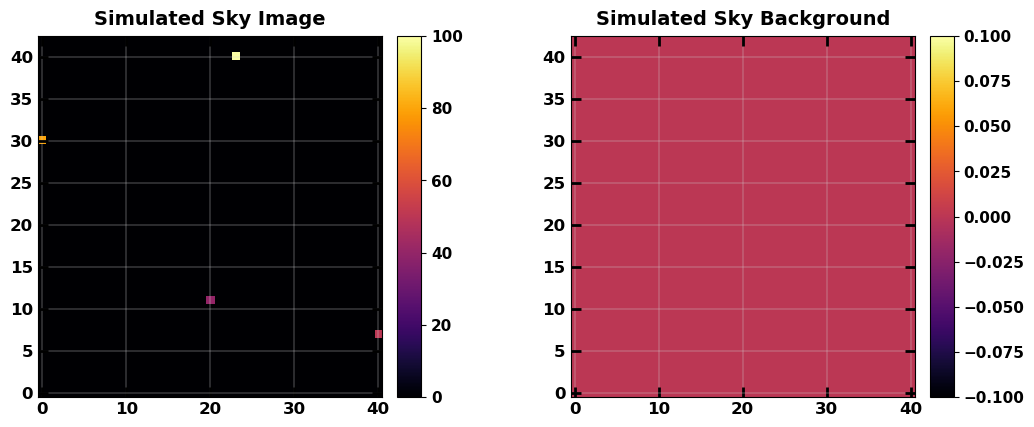

In [14]:
sky_shape = ura_pattern2D.shape
sources_flux = np.array([100, 50, 80, 40])
sources_pos = None #[(sky_shape[0]//2, sky_shape[1]//2)]
sky_background_rate = 0

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

plot.image_plot([sky_image, sky_background],
                ["Simulated Sky Image", "Simulated Sky Background"],
                cbarcmap=["inferno", "inferno"])

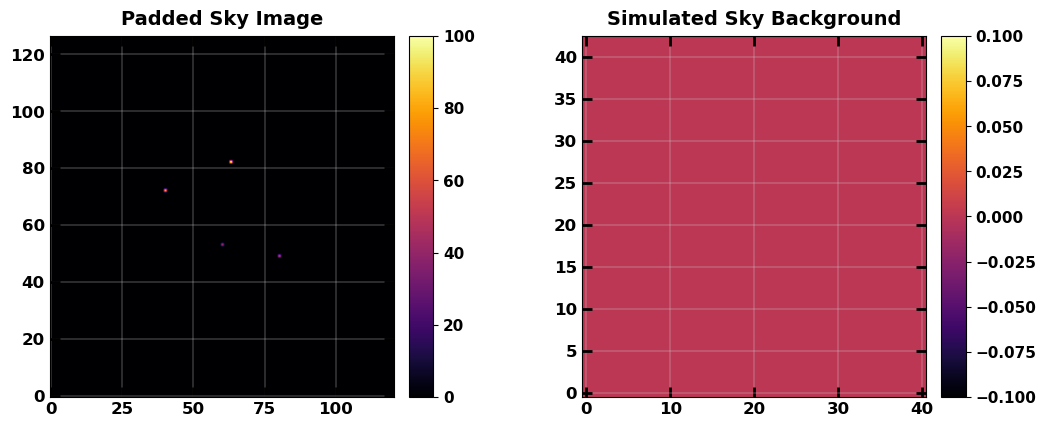

In [15]:
h, v = sky_image.shape[0] - 1, sky_image.shape[1] - 1
hpad, vpad = [h]*2, [v]*2

padded_sky_image = np.pad(sky_image, pad_width=(hpad, vpad))

plot.image_plot([padded_sky_image, sky_background],
                ["Padded Sky Image", "Simulated Sky Background"],
                cbarcmap=["inferno", "inferno"])

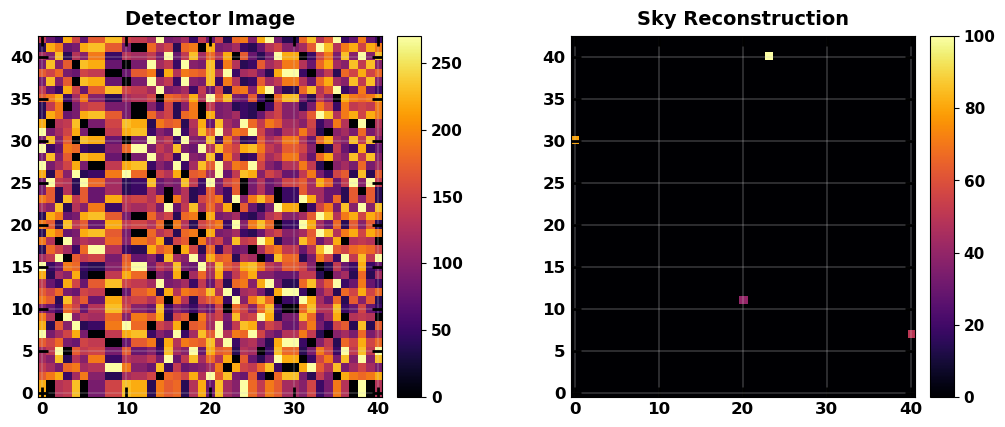

In [16]:
pcfov_detector_image = correlate(mask, padded_sky_image, mode='valid')
pcfov_sky_reconstruction = correlate(decoder, pcfov_detector_image, mode='valid')

plot.image_plot([pcfov_detector_image, pcfov_sky_reconstruction],
                ["Detector Image", "Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"])

- With the full correlation (and comparing with the cutted images):

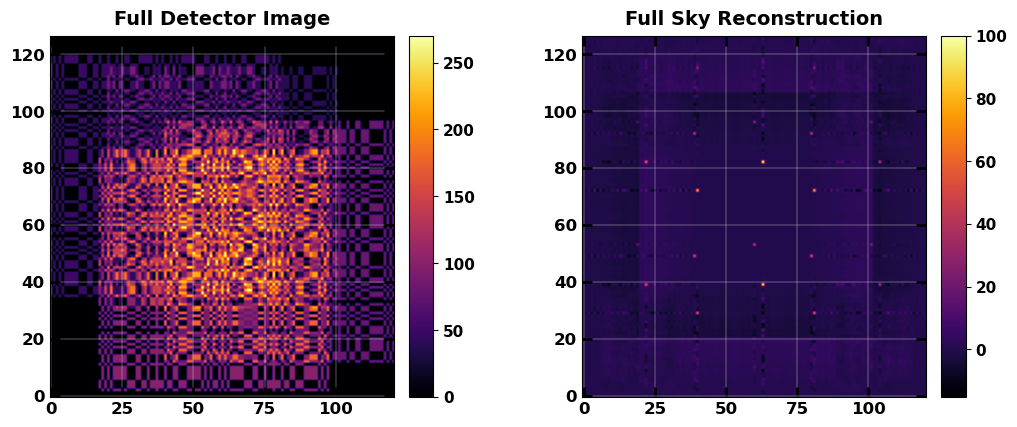

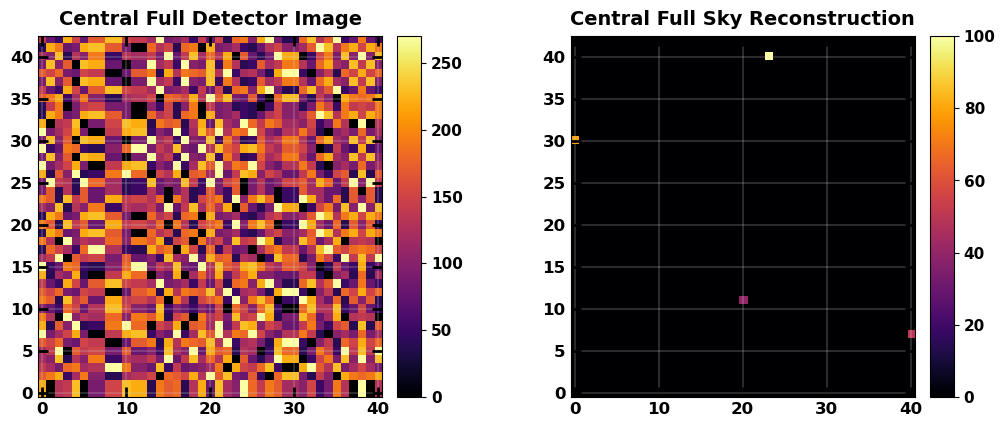

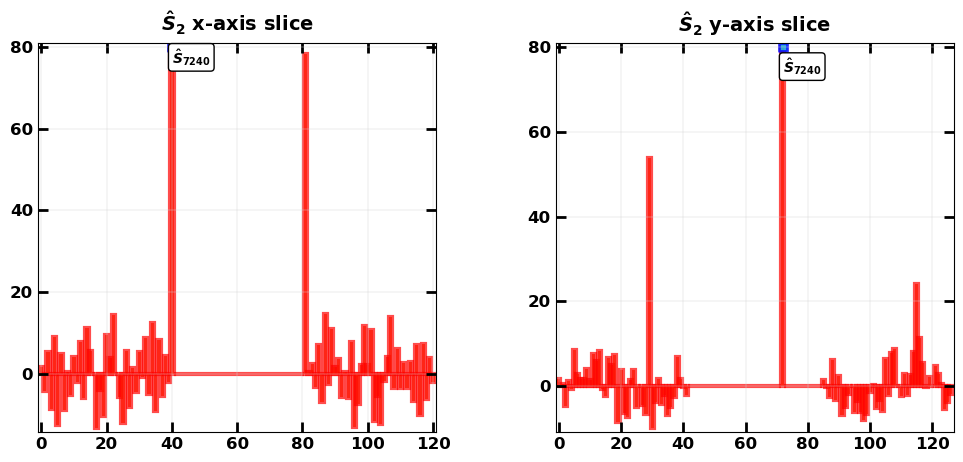

In [17]:
full_detector_image = correlate(mask, sky_image, mode='full')
central_full_detector_image = full_detector_image[h : -h, v : -v]

full_sky_reconstruction = correlate(decoder, central_full_detector_image, mode='full')    ### here the central portion of the detector image
central_full_sky_reconstruction = full_sky_reconstruction[h : -h, v : -v]

plot.image_plot([full_detector_image, full_sky_reconstruction],
                ["Full Detector Image", "Full Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"])

plot.image_plot([central_full_detector_image, central_full_sky_reconstruction],
                ["Central Full Detector Image", "Central Full Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"])


def _pos_mapping(sources_pos, sky_image_shape):
    
    sky_reconstruction_pos = [(s[0] + sky_image_shape[0] - 1, s[1] + sky_image_shape[1] - 1)
                              for s in sources_pos]

    return sky_reconstruction_pos

idx = 2
pos = _pos_mapping(sources_pos, sky_image.shape)[idx]
S_hat_slicex = full_sky_reconstruction[pos[0], :]
S_hat_slicey = full_sky_reconstruction[:, pos[1]]

plot.sequence_plot([S_hat_slicex, S_hat_slicey],
                   [f"$\\hat{{S}}_{idx}$ x-axis slice", f"$\\hat{{S}}_{idx}$ y-axis slice"],
                   style=["bar"]*2,
                   simulated_sources=[(pos[1], *pos, -4), (pos[0], *pos, -6)])

In [18]:
S = sky_image.shape
M = mask.shape
S_hat = full_sky_reconstruction.shape

S_hat[0] == S[0] + M[0] - 1, S_hat[1] == S[1] + M[1] - 1

(True, True)

Decoder: (85, 81)
Full Detector: (127, 121)
Full Sky Reconstruction: (127, 121)
Uncut Sky Reconstruction: (211, 201)
Sky Reconstruction shape = Decoder + Central Full Detector - 1
Uncut Sky Reconstruction shape = Decoder + Full Detector - 1


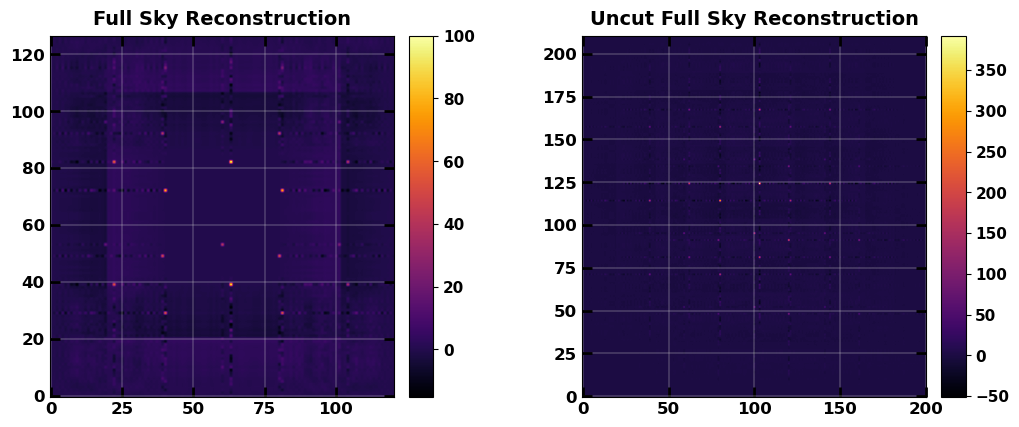

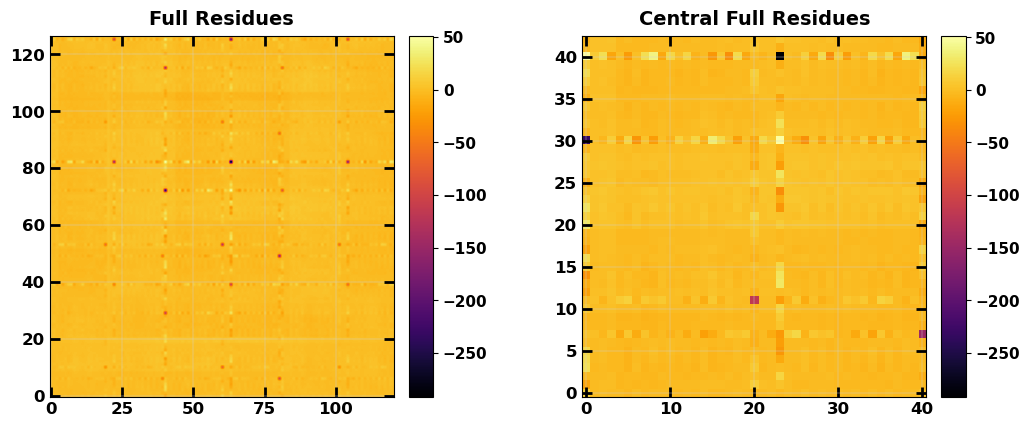

In [19]:
# if the detector image is not cutted:
uncut_sky_rec = correlate(decoder, full_detector_image, mode='full')

print(f"Decoder: {decoder.shape}\n"
      f"Full Detector: {full_detector_image.shape}\n"
      f"Full Sky Reconstruction: {full_sky_reconstruction.shape}\n"
      f"Uncut Sky Reconstruction: {uncut_sky_rec.shape}\n"
      f"Sky Reconstruction shape = Decoder + Central Full Detector - 1\n"
      f"Uncut Sky Reconstruction shape = Decoder + Full Detector - 1")

full_residues = full_sky_reconstruction - uncut_sky_rec[h : -h, v : -v]
central_full_residues = central_full_sky_reconstruction - uncut_sky_rec[2*h : -2*h, 2*v : -2*v]

plot.image_plot([full_sky_reconstruction, uncut_sky_rec],
                ["Full Sky Reconstruction", "Uncut Full Sky Reconstruction"],
                cbarcmap=["inferno"]*2)

plot.image_plot([full_residues, central_full_residues],
                ["Full Residues", "Central Full Residues"],
                cbarcmap=["inferno"]*2)

- Let's finish showing a central source and a more realistic sky image (with sky background)

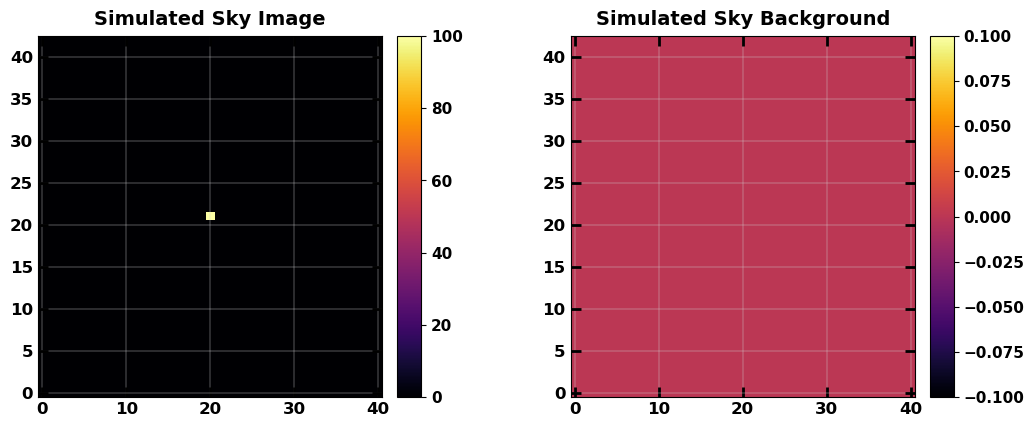

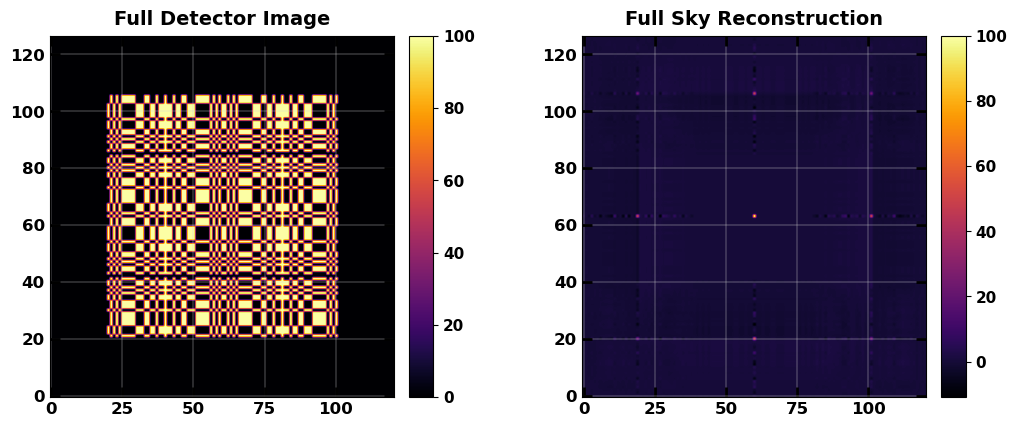

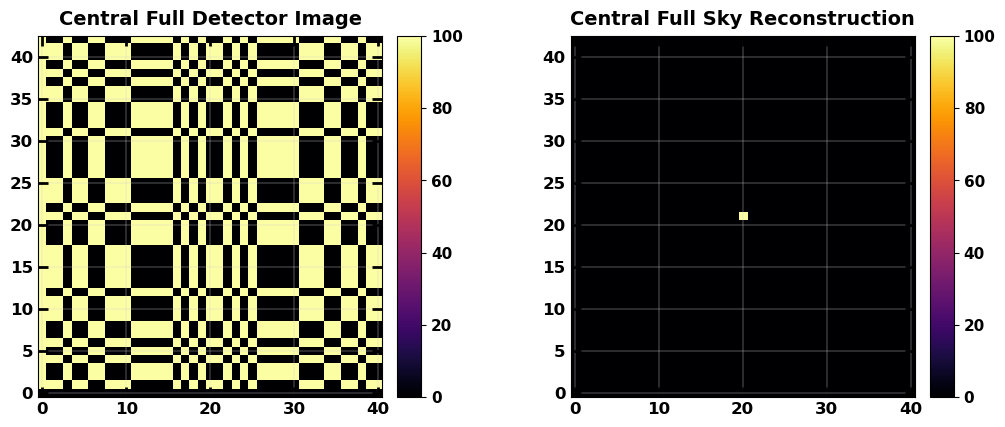

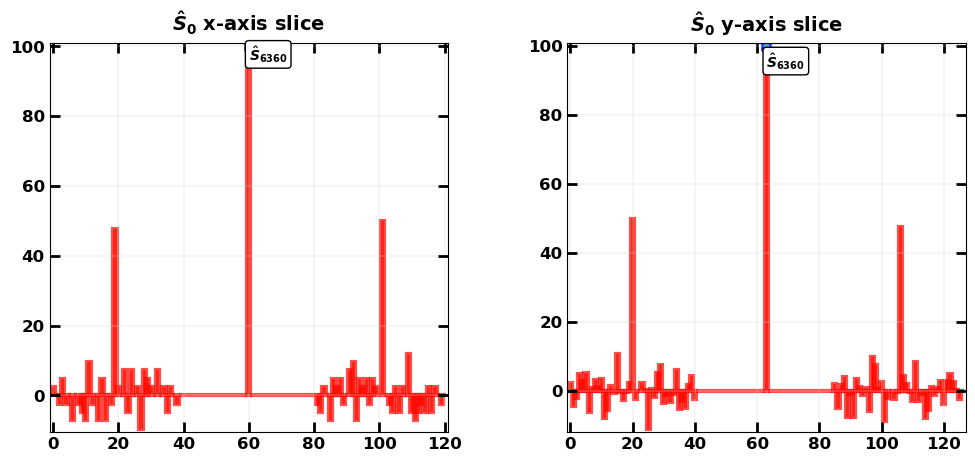

In [20]:
sources_flux = np.array([100])
sources_pos = [(sky_shape[0]//2, sky_shape[1]//2)]
sky_background_rate = 0

sky_image, sky_background, _ = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

plot.image_plot([sky_image, sky_background],
                ["Simulated Sky Image", "Simulated Sky Background"],
                cbarcmap=["inferno", "inferno"])


full_detector_image = correlate(mask, sky_image, mode='full')
central_full_detector_image = full_detector_image[h : -h, v : -v]

full_sky_reconstruction = correlate(decoder, central_full_detector_image, mode='full')    ### here the central portion of the detector image
central_full_sky_reconstruction = full_sky_reconstruction[h : -h, v : -v]

plot.image_plot([full_detector_image, full_sky_reconstruction],
                ["Full Detector Image", "Full Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"])

plot.image_plot([central_full_detector_image, central_full_sky_reconstruction],
                ["Central Full Detector Image", "Central Full Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"])


idx = 0
pos = _pos_mapping(sources_pos, sky_image.shape)[idx]
S_hat_slicex = full_sky_reconstruction[pos[0], :]
S_hat_slicey = full_sky_reconstruction[:, pos[1]]

plot.sequence_plot([S_hat_slicex, S_hat_slicey],
                   [f"$\\hat{{S}}_{idx}$ x-axis slice", f"$\\hat{{S}}_{idx}$ y-axis slice"],
                   style=["bar"]*2,
                   simulated_sources=[(pos[1], *pos, -4), (pos[0], *pos, -6)])

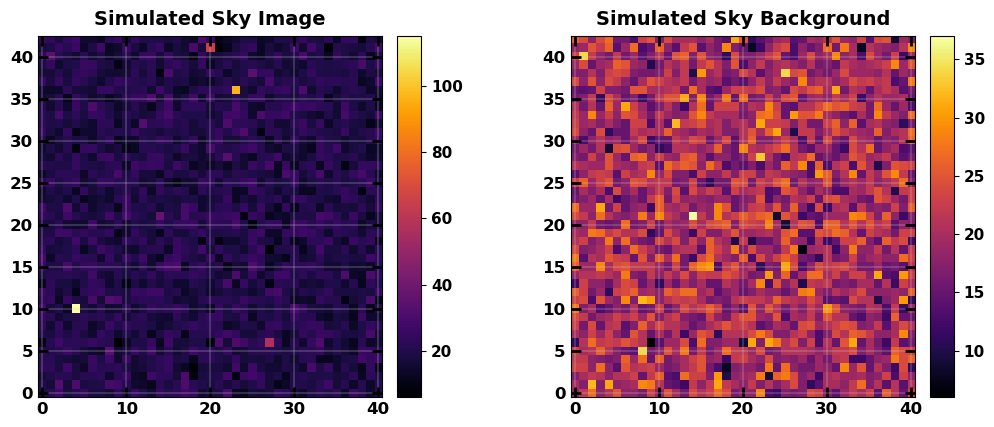

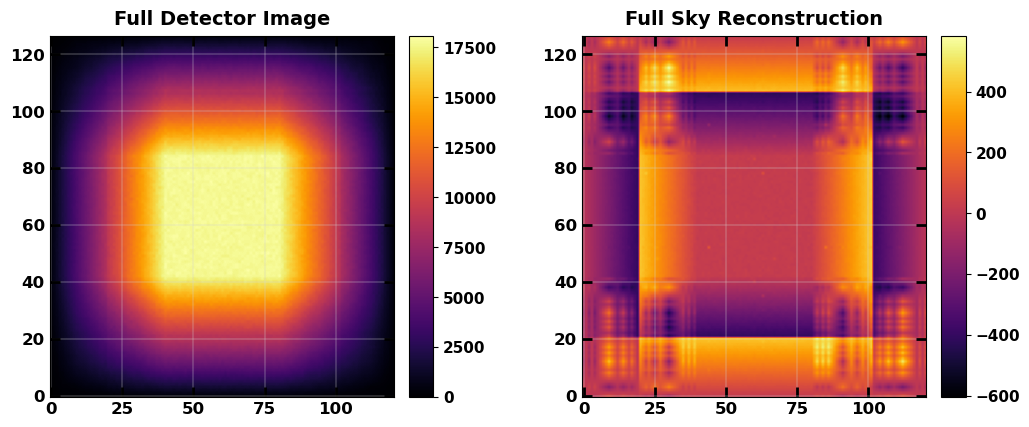

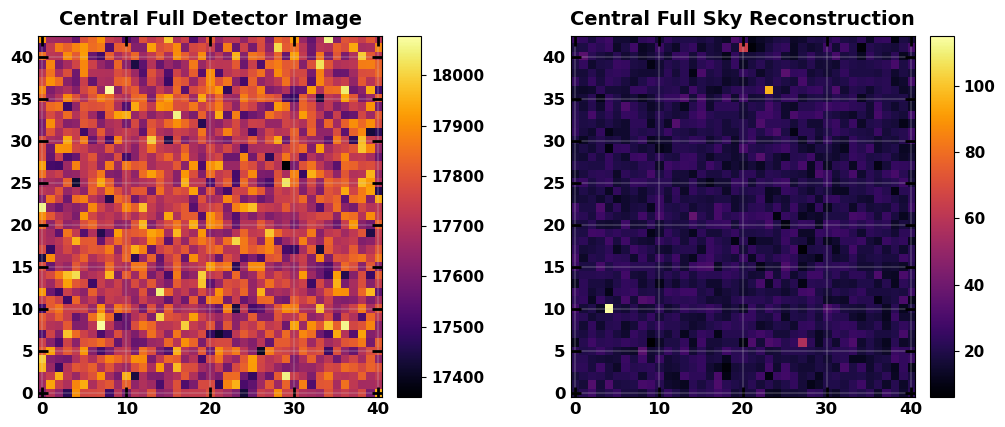

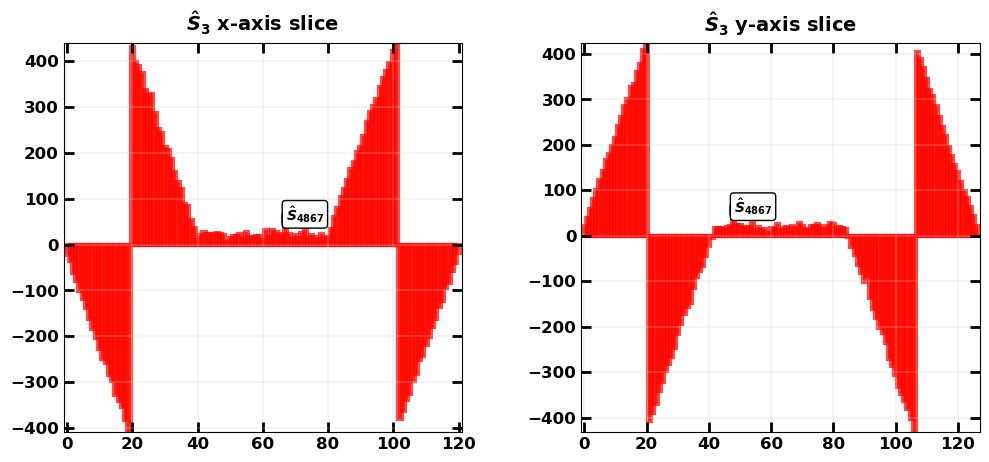

In [22]:
sources_flux = np.array([100, 50, 80, 40])
sources_pos = None
sky_background_rate = 20

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

plot.image_plot([sky_image, sky_background],
                ["Simulated Sky Image", "Simulated Sky Background"],
                cbarcmap=["inferno", "inferno"])


full_detector_image = correlate(mask, sky_image, mode='full')
central_full_detector_image = full_detector_image[h : -h, v : -v]

full_sky_reconstruction = correlate(decoder, central_full_detector_image, mode='full')    ### here the central portion of the detector image
central_full_sky_reconstruction = full_sky_reconstruction[h : -h, v : -v]

plot.image_plot([full_detector_image, full_sky_reconstruction],
                ["Full Detector Image", "Full Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"])

plot.image_plot([central_full_detector_image, central_full_sky_reconstruction],
                ["Central Full Detector Image", "Central Full Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"])


idx = 3
pos = _pos_mapping(sources_pos, sky_image.shape)[idx]
S_hat_slicex = full_sky_reconstruction[pos[0], :]
S_hat_slicey = full_sky_reconstruction[:, pos[1]]

plot.sequence_plot([S_hat_slicex, S_hat_slicey],
                   [f"$\\hat{{S}}_{idx}$ x-axis slice", f"$\\hat{{S}}_{idx}$ y-axis slice"],
                   style=["bar"]*2,
                   simulated_sources=[(pos[1], *pos, -4), (pos[0], *pos, -6)])

<br>

### **Sources in the PCFOV**

- Let's now consider a whole sky image with possible sources in the PCFOV

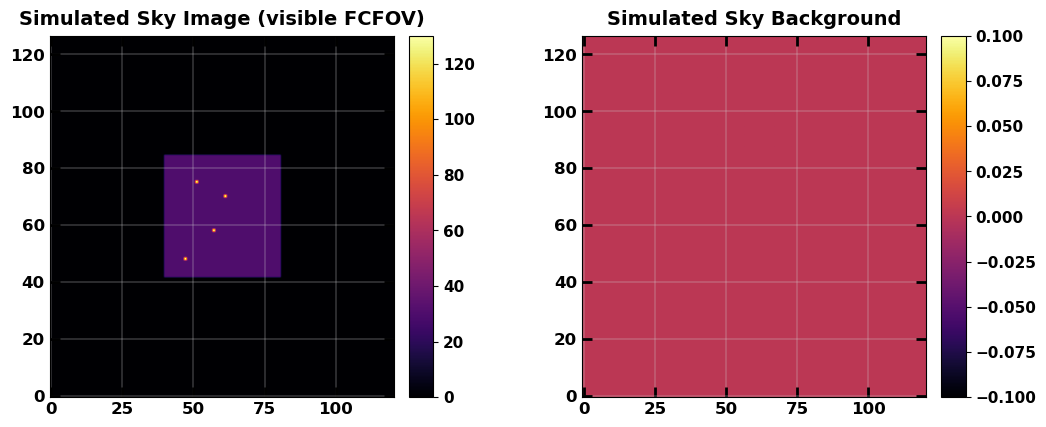

In [48]:
n, m = ura_pattern2D.shape
h, v = n - 1, m - 1
sky_shape = (n + 2*h, m + 2*v)

sources_flux = np.array([100, 100, 100, 100])
sources_pos = [(h + n - 15, v + m - 20), (n + 5, m + 6), (n + 15, m + 16), (h + n - 10, v + m - 30)]
sky_background_rate = 0

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

highlight_fcfov = True
if highlight_fcfov:
    c_edge = 30*np.ones((n, m))
    sky_image_wfcfov = sky_image.copy()
    sky_image_wfcfov[h : -h, v : -v] += c_edge

    plot.image_plot([sky_image_wfcfov, sky_background],
                    ["Simulated Sky Image (visible FCFOV)", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"])

else:
    plot.image_plot([sky_image, sky_background],
                    ["Simulated Sky Image", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"])

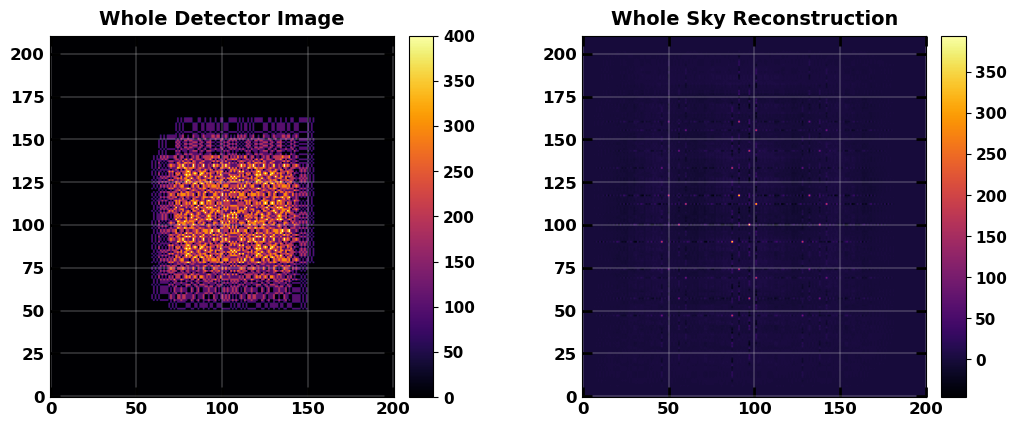

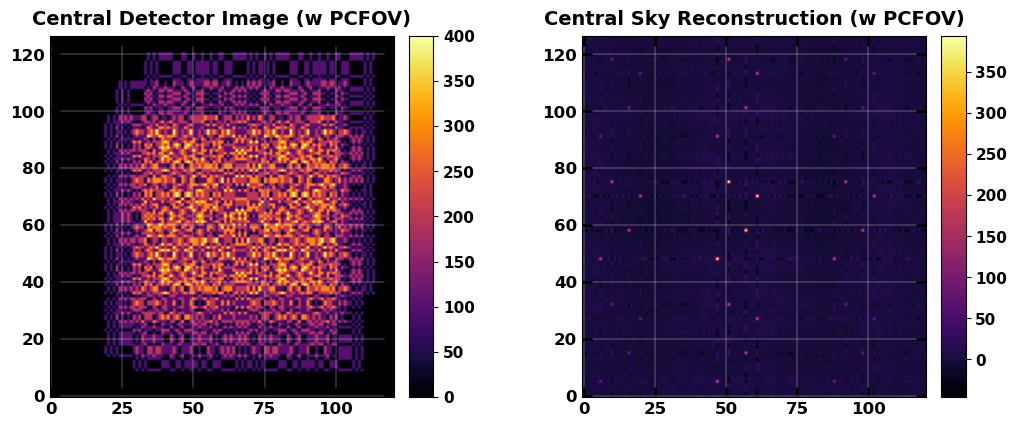

In [53]:
whole_detector_image = correlate(mask, sky_image, mode='full')
central_whole_detector_image = whole_detector_image[h : -h, v : -v]

whole_sky_reconstruction = correlate(decoder, central_whole_detector_image, mode='full')    ### here the central portion of the detector image
central_whole_sky_reconstruction = whole_sky_reconstruction[h : -h, v : -v]

plot.image_plot([whole_detector_image, whole_sky_reconstruction],
                ["Whole Detector Image", "Whole Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"])

plot.image_plot([central_whole_detector_image, central_whole_sky_reconstruction],
                ["Central Detector Image (w PCFOV)", "Central Sky Reconstruction (w PCFOV)"],
                cbarcmap=["inferno", "inferno"])

- The whole sky reconstruction should contain both the PCFOV (central section) and the zero-response zone (where the photons do not arrive to the detector)

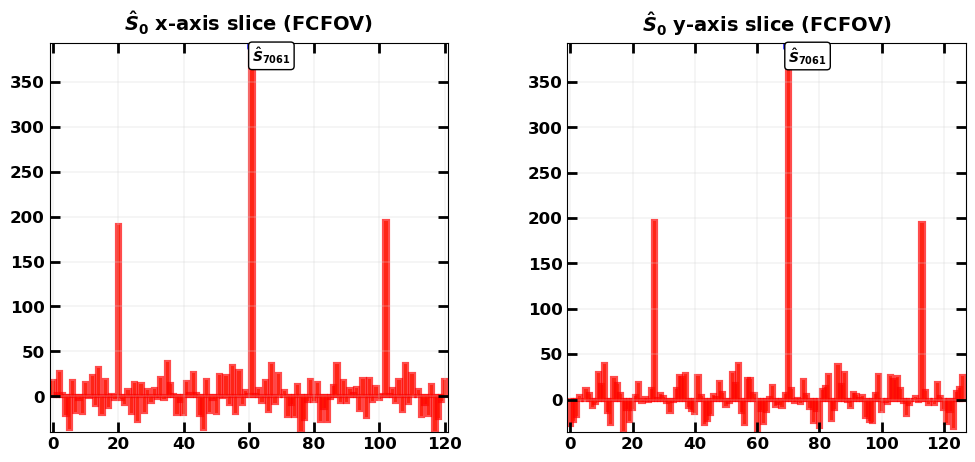

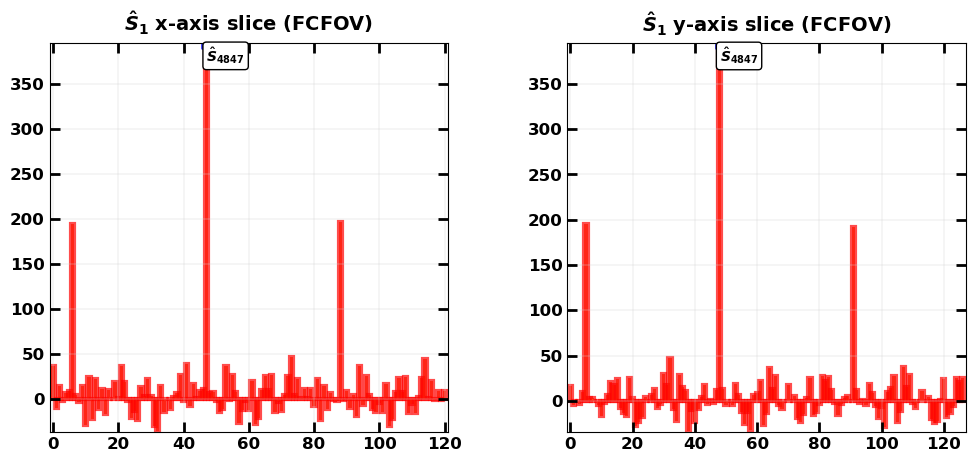

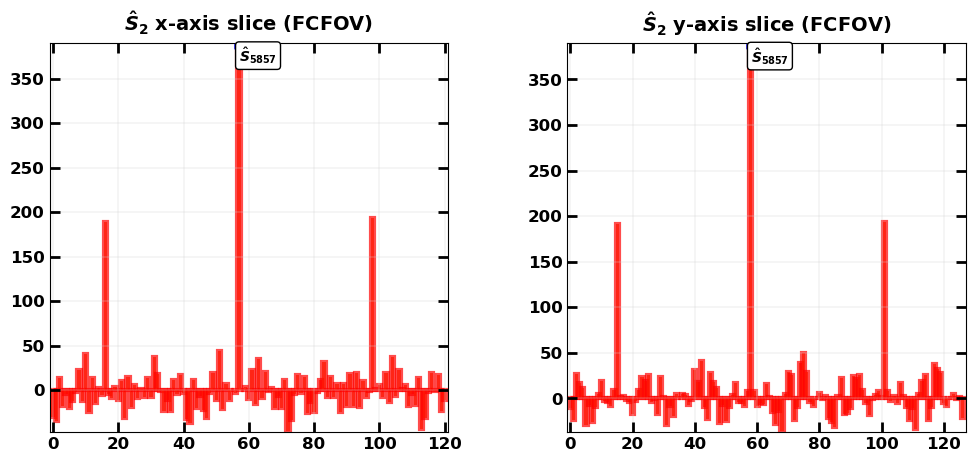

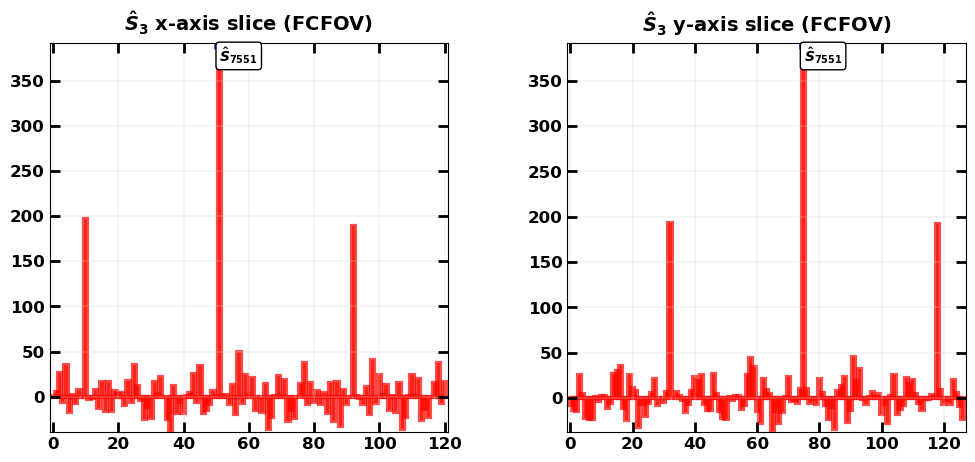

In [50]:
center = (len(central_whole_sky_reconstruction)//2, len(central_whole_sky_reconstruction)//2)
pos_wrt_center = [(pos[0] - center[0], pos[1] - center[1]) for _, pos in enumerate(sources_pos)]


for idx, pos in enumerate(sources_pos):
    S_hat_slicex = central_whole_sky_reconstruction[pos[0], :]
    S_hat_slicey = central_whole_sky_reconstruction[:, pos[1]]

    if (np.abs(pos_wrt_center[idx][0]) < n//2) and (np.abs(pos_wrt_center[idx][1]) < m//2):
        zone = " (FCFOV)"
    else:
        zone = " (PCFOV)"

    plot.sequence_plot([S_hat_slicex, S_hat_slicey],
                    [f"$\\hat{{S}}_{idx}$ x-axis slice" + zone, f"$\\hat{{S}}_{idx}$ y-axis slice" + zone],
                    style=["bar"]*2,
                    simulated_sources=[(pos[1], *pos, -20), (pos[0], *pos, -20)])

- The sources in the PCFOV project part of the mask pattern in the FCFOV, generating peaks linked to coding noise also in the FCFOV

- Moreover, the reconstructed flux counts are not correct at all ($\sim 2-3\times$ the original fluxes)

- **NOTE:** this implementation shows an error, since even if the sources are in the FCFOV only, there is still coding noise in the FCFOV

- **SEE IMPLEMENTATION AFTER BALANCING**

<br>

### **Balancing**

- Let's see how **balancing** works to reduce the coding noise due to:
    1. the projection of the mask elements from the FCFOV sources that fall in the PCFOV
    2. the projection of the mask elements from the PCFOV sources

**1. Balancing with formula from Peppe**

- The formula from Peppe for balancing the effect of sources in the PCFOV on the FCFOV is:

$$\hat{S} = G \star D - G \star W \cdot {\sum d_{i} \over \sum w_{i}}$$

- $W$ is the bulk array or sensitive array, an array of weights for the detector response (values between 0 and 1).

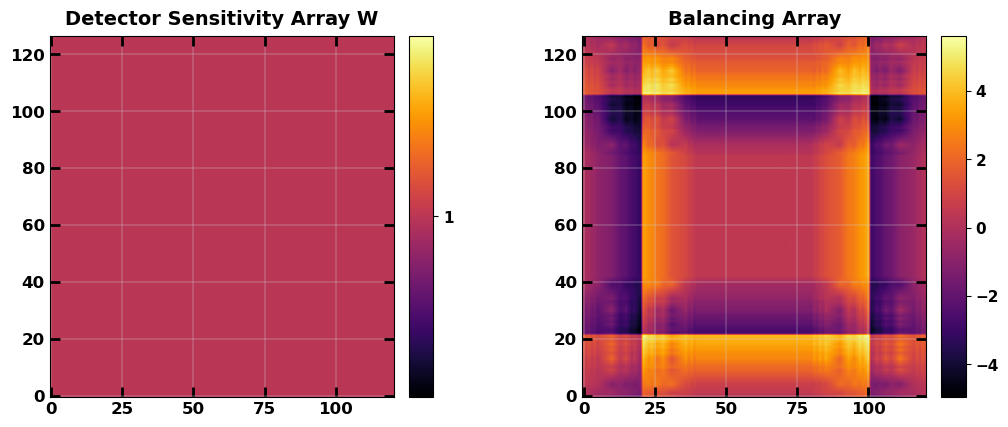

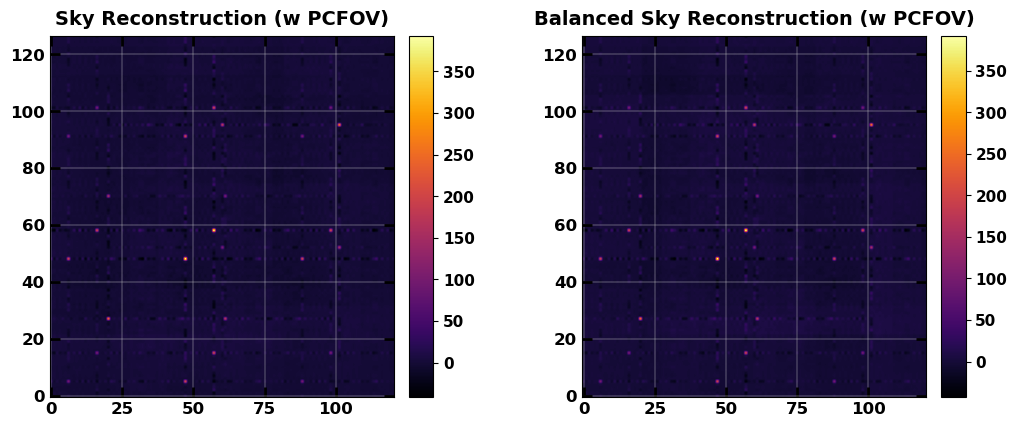

In [47]:
bulk_array = np.ones(central_whole_detector_image.shape)    # fully responsive detector

balancing_array = correlate(decoder, bulk_array, mode='full')[h : -h, v : -v]
balancing_array *= (central_whole_detector_image.sum()/bulk_array.sum())

plot.image_plot([bulk_array, balancing_array],
                ["Detector Sensitivity Array W", "Balancing Array"],
                cbarvalues=[[0, 1], None],
                cbarcmap=["inferno", "inferno"])

balanced_sky_reconstruction = central_whole_sky_reconstruction - balancing_array

plot.image_plot([central_whole_sky_reconstruction, balanced_sky_reconstruction],
                ["Sky Reconstruction (w PCFOV)", "Balanced Sky Reconstruction (w PCFOV)"],
                cbarcmap=["inferno", "inferno"])

In [41]:
show_balanced_slices = False

if show_balanced_slices:
    for idx, pos in enumerate(sources_pos):
        S_hat_slicex = balanced_sky_reconstruction[pos[0], :]
        S_hat_slicey = balanced_sky_reconstruction[:, pos[1]]

        if (np.abs(pos_wrt_center[idx][0]) < n//2) and (np.abs(pos_wrt_center[idx][1]) < m//2):
            zone = " (FCFOV)"
        else:
            zone = " (PCFOV)"

        plot.sequence_plot([S_hat_slicex, S_hat_slicey],
                        [f"Balanced $\\hat{{S}}_{idx}$ x-axis slice" + zone, f"Balanced $\\hat{{S}}_{idx}$ y-axis slice" + zone],
                        style=["bar"]*2,
                        simulated_sources=[(pos[1], *pos, -20), (pos[0], *pos, -20)])

<br>

### **Sky Reconstruction through detector FCFOV only**

- Let's see what happens if in the sky decoding one uses only the image area corresponding to the FCFOV, since even if we have sources in the PCFOV their encoding should appear within the FCFOV

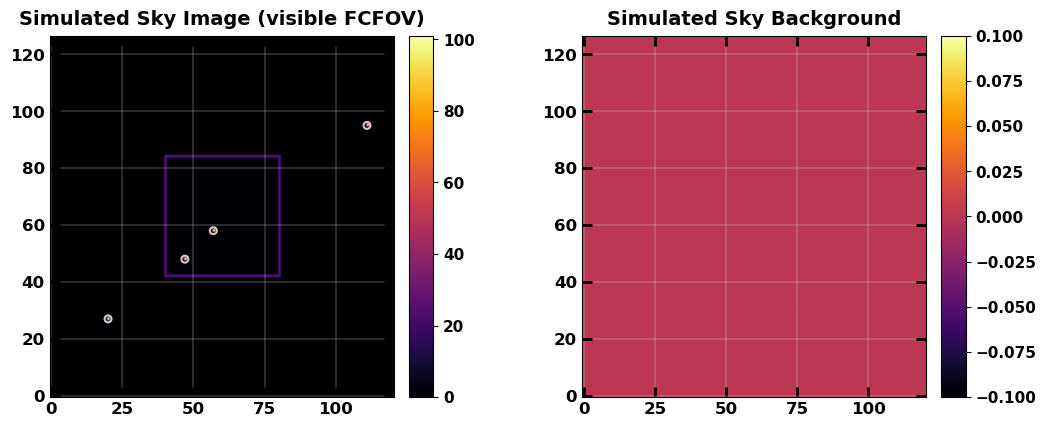

In [6]:
n, m = ura_pattern2D.shape
h, v = n - 1, m - 1
sky_shape = (n + 2*h, m + 2*v)

sources_flux = np.array([100, 100, 100, 100])
sources_pos = [(h - 15, v - 20), (n + 5, m + 6), (n + 15, m + 16), (h + n + 10, v + m + 30)]
sky_background_rate = 0

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

highlight_fcfov = True
if highlight_fcfov:
    base = np.ones((n - 2, m - 2))
    c_edge = np.pad(base, pad_width=[(1, 1), (1, 1)], constant_values=sources_flux.max()//4)

    sky_image_wfcfov = sky_image.copy()
    sky_image_wfcfov[h : -h, v : -v] += c_edge

    plot.image_plot([sky_image_wfcfov, sky_background],
                    ["Simulated Sky Image (visible FCFOV)", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"],
                    simulated_sources=[sources_pos, None])

else:
    plot.image_plot([sky_image, sky_background],
                    ["Simulated Sky Image", "Simulated Sky Background"],
                    cbarcmap=["inferno", "inferno"],
                    simulated_sources=[sources_pos, None])

central_whole_detector_image shape = sky image shape: True
pcfov_sky_reconstruction = sky image shape: True
fcfov_sky_reconstruction = basic pattern shape: True


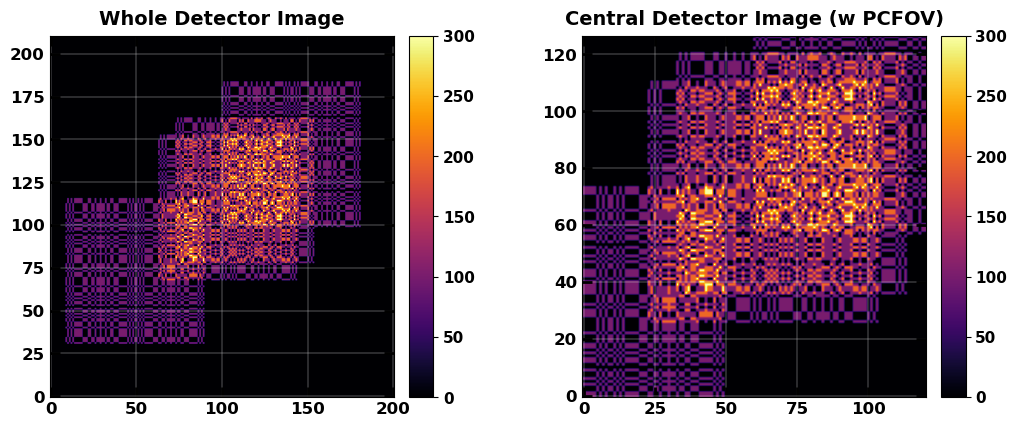

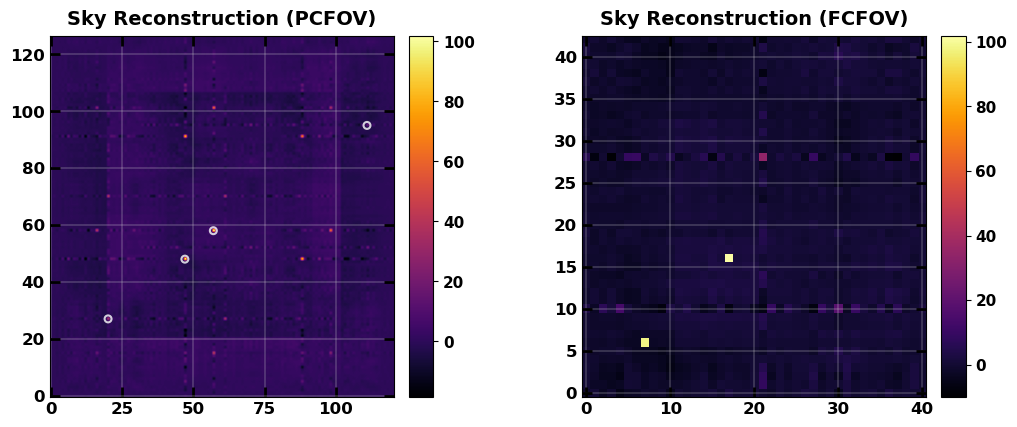

In [7]:
whole_detector_image = correlate(mask, sky_image, mode='full')
central_whole_detector_image = whole_detector_image[h : -h, v : -v]
fcfov_detector_image = whole_detector_image[2*h : -2*h, 2*v : -2*v]                 ### detector area corresponding to FCFOV

pcfov_sky_reconstruction = correlate(decoder, fcfov_detector_image, mode='full')    ### here the FCFOV portion of the central detector image
fcfov_sky_reconstruction = pcfov_sky_reconstruction[h : -h, v : -v]

print(f"central_whole_detector_image shape = sky image shape: {np.all(central_whole_detector_image.shape == sky_shape)}\n"
      f"pcfov_sky_reconstruction = sky image shape: {np.all(pcfov_sky_reconstruction.shape == sky_shape)}\n"
      f"fcfov_sky_reconstruction = basic pattern shape: {np.all(fcfov_sky_reconstruction.shape == (n, m))}")

plot.image_plot([whole_detector_image, central_whole_detector_image],
                ["Whole Detector Image", "Central Detector Image (w PCFOV)"],
                cbarcmap=["inferno", "inferno"])

plot.image_plot([pcfov_sky_reconstruction, fcfov_sky_reconstruction],
                ["Sky Reconstruction (PCFOV)", "Sky Reconstruction (FCFOV)"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[sources_pos, None])

- Depending on the presence or not of sources in the sky PCFOV, in the "Sky Reconstruction (FCFOV)" image false peaks are present due to coding noise (which is less intense than the reconstructed sources in the previous implementation). This should be caused by the projection of the mask elements in the FCFOV (as shown in the two detector images)

- Moreover, here the flux counts are correct wrt the first implementation (above **Balancing**)

- If there are no sources in the PCFOV, the sky reconstruction should be perfect (as it is in this implementation)

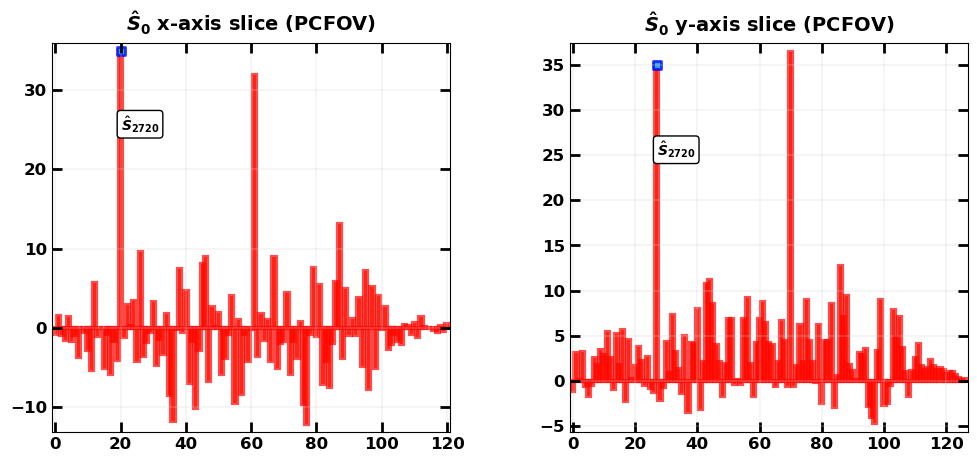

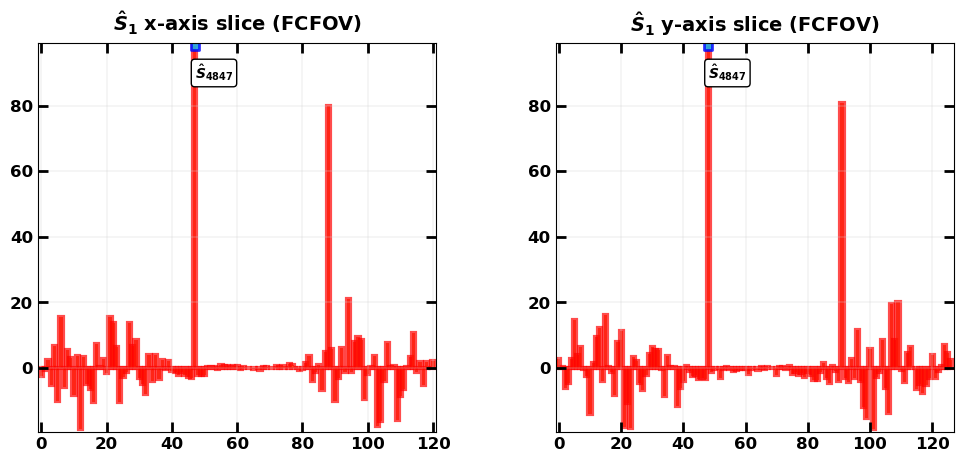

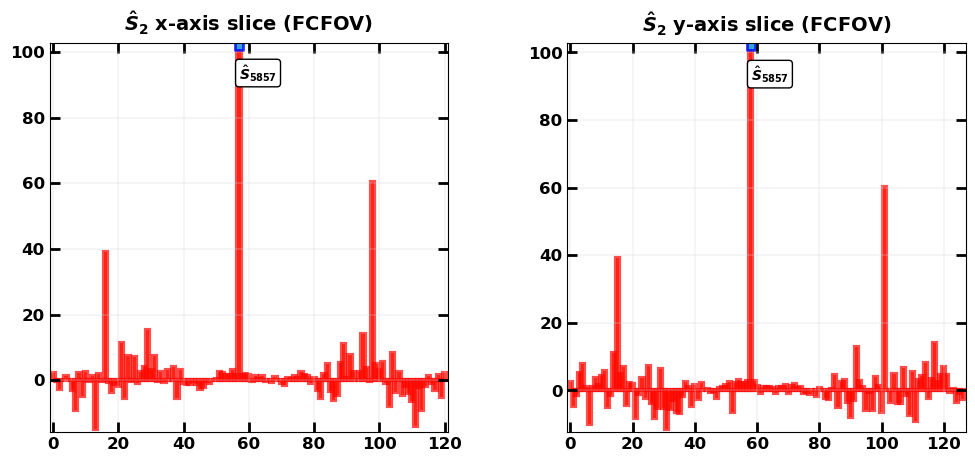

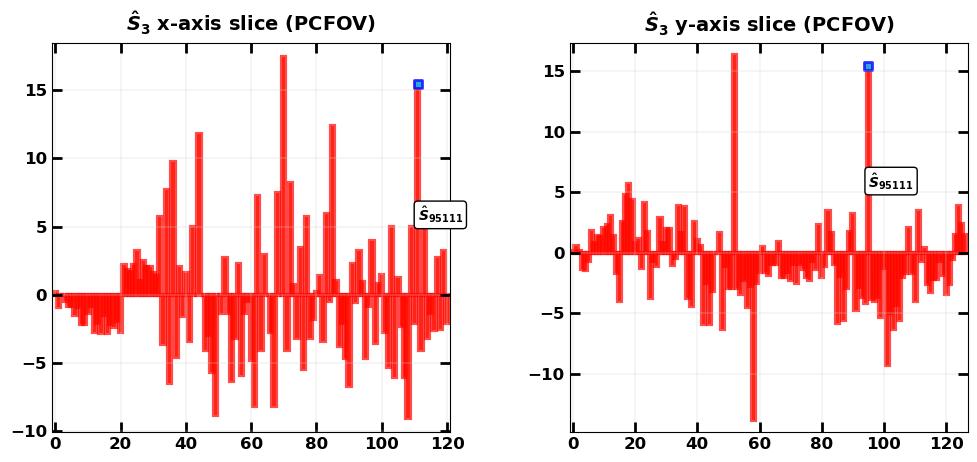

In [8]:
center = (len(pcfov_sky_reconstruction)//2, len(pcfov_sky_reconstruction)//2)
pos_wrt_center = [(pos[0] - center[0], pos[1] - center[1]) for _, pos in enumerate(sources_pos)]


for idx, pos in enumerate(sources_pos):
    S_hat_slicex = pcfov_sky_reconstruction[pos[0], :]
    S_hat_slicey = pcfov_sky_reconstruction[:, pos[1]]

    if (np.abs(pos_wrt_center[idx][0]) < n//2) and (np.abs(pos_wrt_center[idx][1]) < m//2):
        zone = " (FCFOV)"
    else:
        zone = " (PCFOV)"

    plot.sequence_plot([S_hat_slicex, S_hat_slicey],
                    [f"$\\hat{{S}}_{idx}$ x-axis slice" + zone, f"$\\hat{{S}}_{idx}$ y-axis slice" + zone],
                    style=["bar"]*2,
                    simulated_sources=[(pos[1], *pos, -10), (pos[0], *pos, -10)])

- Let's apply again the reconstruction **balancing**

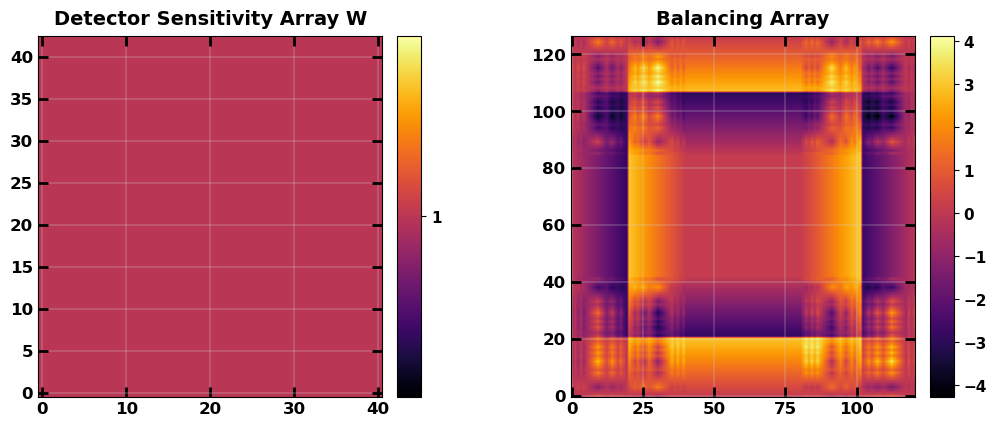

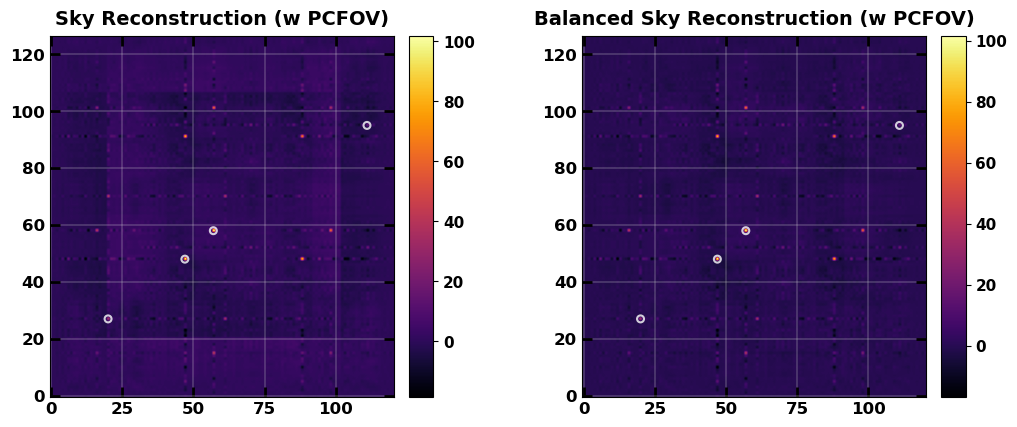

In [9]:
bulk_array = np.ones(fcfov_detector_image.shape)    # fully responsive detector

balancing_array = correlate(decoder, bulk_array, mode='full')
balancing_array *= (fcfov_detector_image.sum()/bulk_array.sum())

assert balancing_array.shape == pcfov_sky_reconstruction.shape

plot.image_plot([bulk_array, balancing_array],
                ["Detector Sensitivity Array W", "Balancing Array"],
                cbarvalues=[[0, 1], None],
                cbarcmap=["inferno", "inferno"])

balanced_sky_reconstruction = pcfov_sky_reconstruction - balancing_array

plot.image_plot([pcfov_sky_reconstruction, balanced_sky_reconstruction],
                ["Sky Reconstruction (w PCFOV)", "Balanced Sky Reconstruction (w PCFOV)"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[sources_pos, sources_pos])

- If one adds the sky background without taking into account the **different sensitivity in the PCFOV**, the reconstruction will be very bad, since the sky background in the PCFOV will act like multiple sources from everywhere

- The role of the balancing emerges though (but it's only an artifact), showing the reduction of the coding noise

- In general, also the sources in the PCFOV will be collected less efficiently

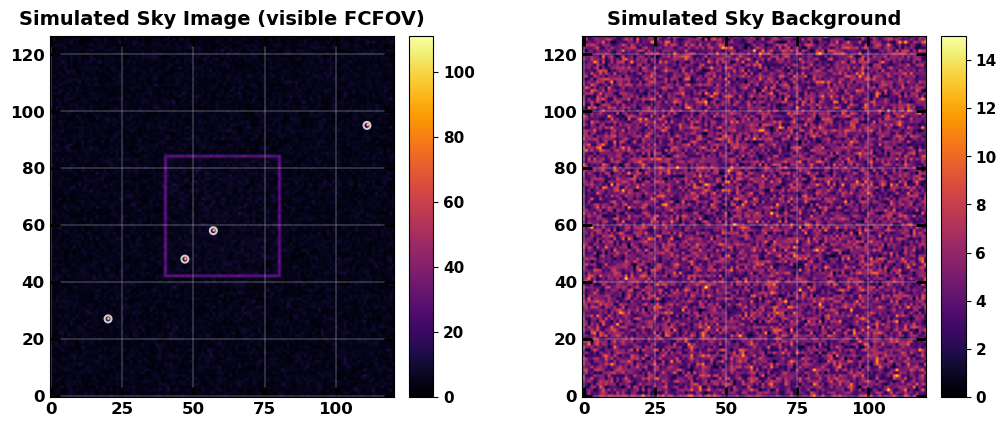

central_whole_detector_image shape = sky image shape: True
pcfov_sky_reconstruction = sky image shape: True
fcfov_sky_reconstruction = basic pattern shape: True


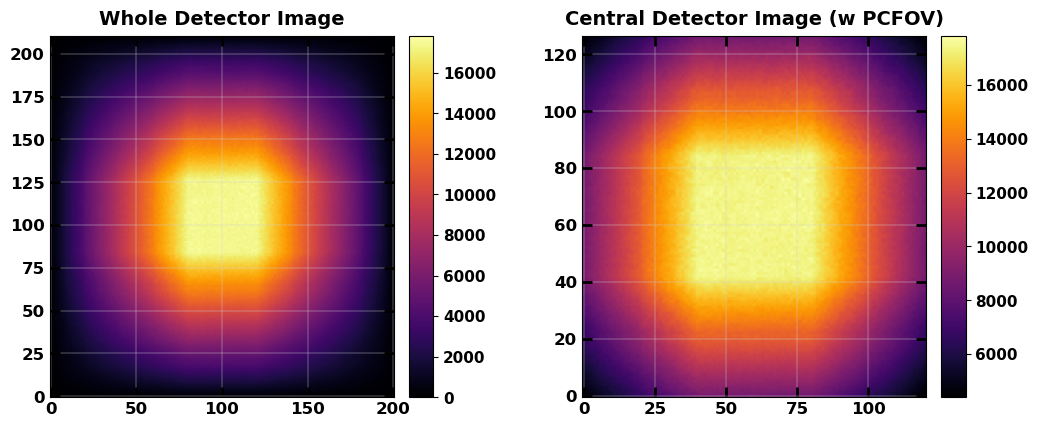

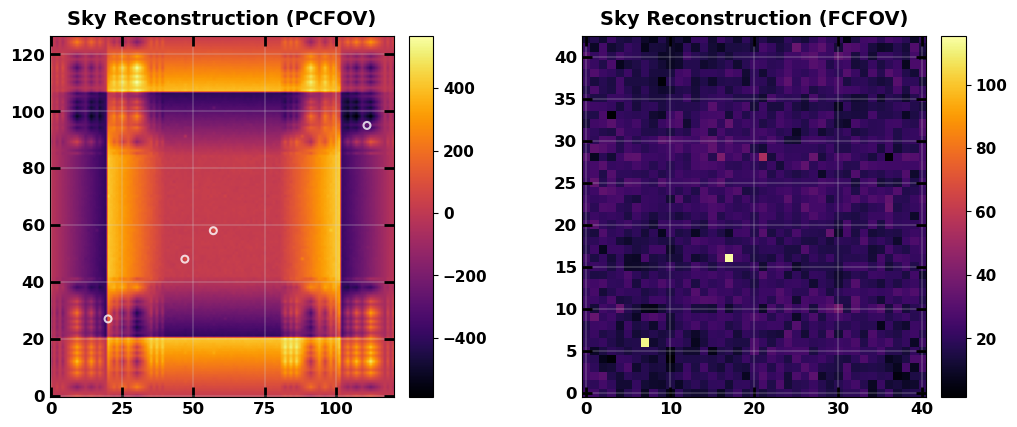

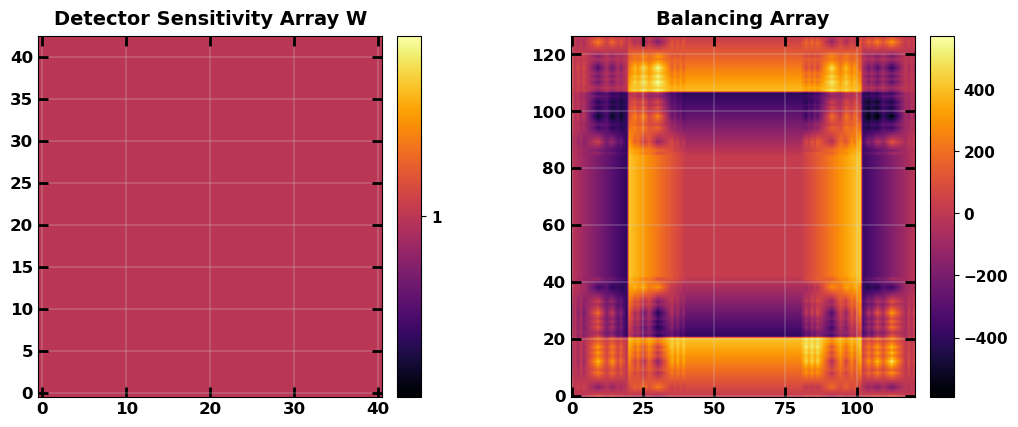

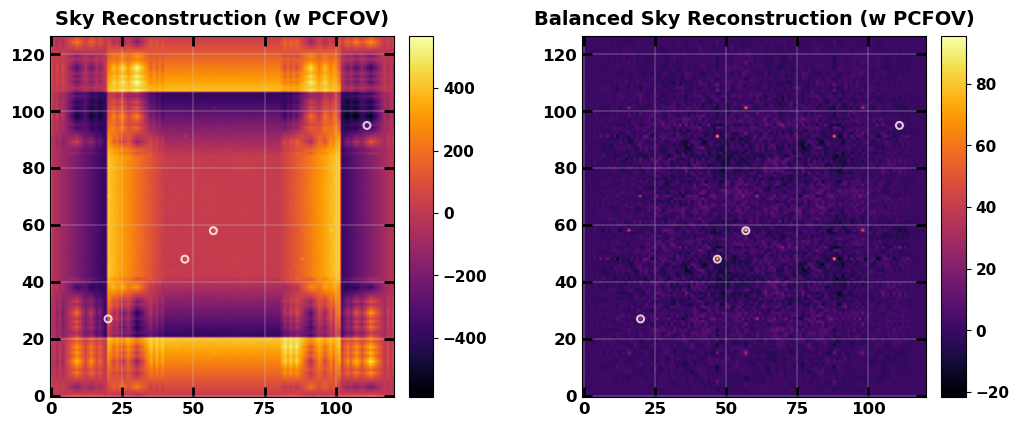

In [23]:
sky_background_rate = 5

sky_image, sky_background, sources_pos = sky_image_simulation(sky_shape, sources_flux, sources_pos, sky_background_rate)

base = np.ones((n - 2, m - 2))
c_edge = np.pad(base, pad_width=[(1, 1), (1, 1)], constant_values=sources_flux.max()//4)

sky_image_wfcfov = sky_image.copy()
sky_image_wfcfov[h : -h, v : -v] += c_edge

plot.image_plot([sky_image_wfcfov, sky_background],
                ["Simulated Sky Image (visible FCFOV)", "Simulated Sky Background"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[sources_pos, None])



whole_detector_image = correlate(mask, sky_image, mode='full')
central_whole_detector_image = whole_detector_image[h : -h, v : -v]
fcfov_detector_image = whole_detector_image[2*h : -2*h, 2*v : -2*v]                 ### detector area corresponding to FCFOV

pcfov_sky_reconstruction = correlate(decoder, fcfov_detector_image, mode='full')    ### here the FCFOV portion of the central detector image
fcfov_sky_reconstruction = pcfov_sky_reconstruction[h : -h, v : -v]

print(f"central_whole_detector_image shape = sky image shape: {np.all(central_whole_detector_image.shape == sky_shape)}\n"
      f"pcfov_sky_reconstruction = sky image shape: {np.all(pcfov_sky_reconstruction.shape == sky_shape)}\n"
      f"fcfov_sky_reconstruction = basic pattern shape: {np.all(fcfov_sky_reconstruction.shape == (n, m))}")

plot.image_plot([whole_detector_image, central_whole_detector_image],
                ["Whole Detector Image", "Central Detector Image (w PCFOV)"],
                cbarcmap=["inferno", "inferno"])

plot.image_plot([pcfov_sky_reconstruction, fcfov_sky_reconstruction],
                ["Sky Reconstruction (PCFOV)", "Sky Reconstruction (FCFOV)"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[sources_pos, None])



bulk_array = np.ones(fcfov_detector_image.shape)    # fully responsive detector

balancing_array = correlate(decoder, bulk_array, mode='full')
balancing_array *= (fcfov_detector_image.sum()/bulk_array.sum())

assert balancing_array.shape == pcfov_sky_reconstruction.shape

plot.image_plot([bulk_array, balancing_array],
                ["Detector Sensitivity Array W", "Balancing Array"],
                cbarvalues=[[0, 1], None],
                cbarcmap=["inferno", "inferno"])

balanced_sky_reconstruction = pcfov_sky_reconstruction - balancing_array

plot.image_plot([pcfov_sky_reconstruction, balanced_sky_reconstruction],
                ["Sky Reconstruction (w PCFOV)", "Balanced Sky Reconstruction (w PCFOV)"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[sources_pos, sources_pos])

<br>

### **Balancing**

**2. Balancing with formula from Goldwurm**

- The formula from Goldwurm for balancing the effect of sources in the PCFOV on the FCFOV can be found in:

    **[1]** A. Goldwurm and A. Gros, "Coded Mask Instruments for Gamma-Ray Astronomy", 2023 (in "Handbook of X-ray and Gamma-ray Astrophysics", Springer 2023)

<br>

- In this formalism, the decoder is splitted in the $G^{+}$ and $G^{-}$ terms so that $G = G^{+} + G^{-}$, and the reconstructed sky is obtained consider again a bulk array $W$ and a balancing array $B$ that weights the contributes from the decoding pattern:

$$\hat{S} = {G^{+} \star (D\cdot W) - B \cdot [G^{-} \star (D\cdot W)] \over N}$$

- where:

    - $W$ is the bulk array or sensitive array, an array of weights for the detector response (values between 0 and 1)
    - $B$ is the balancing array $$B = {G^{+} \star W \over G^{-} \star W}$$
    - $N$ is a normalization array $$N = {(G^{+}\cdot A) \star W - B \cdot [(G^{-}\cdot A) \star W}]$$

<br>

- The balance array $B$ is used to account for the different open to closed mask element ratio and ensures a flat image with zero mean in absence of sources

- The normalization array allows a correct source flux reconstruction which takes into account the partial modulation. With this normalization the sky reconstruction gives at the source peak the mean recorded source counts within one totally illuminated detector pixel.

In [36]:
class SkyReconstructionBalancing:
    def __init__(self, mask, decoder, bulk):
        self.mask = mask
        self.decoder = decoder
        self.bulk = bulk
    
    def balanced_sky_reconstruction(self, detector_image):

        G_plus, G_minus = self._get_decoder_terms()
        B = self._get_balancing_array(G_plus, G_minus)
        N = self._get_normalization(G_plus, G_minus, B)

        gplus_cc_term = self._cc(G_plus, detector_image)
        gminus_cc_term = self._cc(G_minus, detector_image)

        S_hat = (gplus_cc_term - B*gminus_cc_term)/N
        
        return S_hat
    
    def _get_decoder_terms(self):
        G_plus = self.decoder.copy()
        G_plus[self.decoder < 0] = 0
        G_minus = self.decoder.copy()
        G_minus[self.decoder > 0] = 0
        assert np.all(G_plus + G_minus == self.decoder)
        return G_plus, G_minus

    def _get_balancing_array(self, G_plus, G_minus):
        num = correlate(G_plus, self.bulk, mode=self._cc_mode)
        den = correlate(G_minus, self.bulk, mode=self._cc_mode)
        assert num.shape == (n + 2*h, m + 2*v)
        assert den.shape == (n + 2*h, m + 2*v)
        return num/den

    def _get_normalization(self, G_plus, G_minus, B):
        gplus_norm = correlate(G_plus*self.mask, self.bulk, mode=self._cc_mode)
        if np.all(G_minus*self.mask != np.zeros(G_minus.shape)): # for URA/MURA G_ * mask = 0
            gminus_norm = B*correlate(G_minus*self.mask, self.bulk, mode=self._cc_mode)
        else:
            gminus_norm = np.zeros(gplus_norm.shape)
        assert gplus_norm.shape == (n + 2*h, m + 2*v)
        assert gplus_norm.shape == gminus_norm.shape
        return gplus_norm - gminus_norm

    def _cc(self, g, detector_image):
        cc = correlate(g, detector_image*self.bulk, mode=self._cc_mode)
        assert cc.shape == (n + 2*h, m + 2*v)
        return cc

    @property
    def _cc_mode(self):
        return 'full'

- Let's try to balance the sky reconstruction in the previous implementation

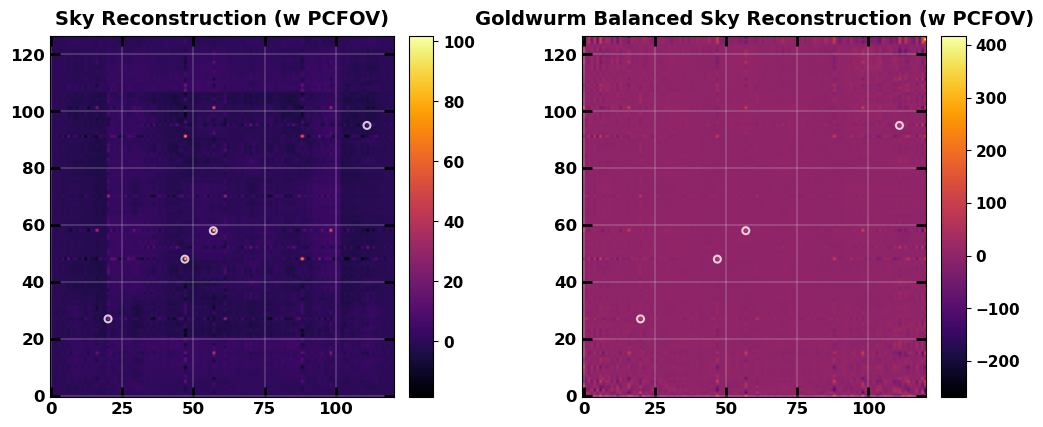

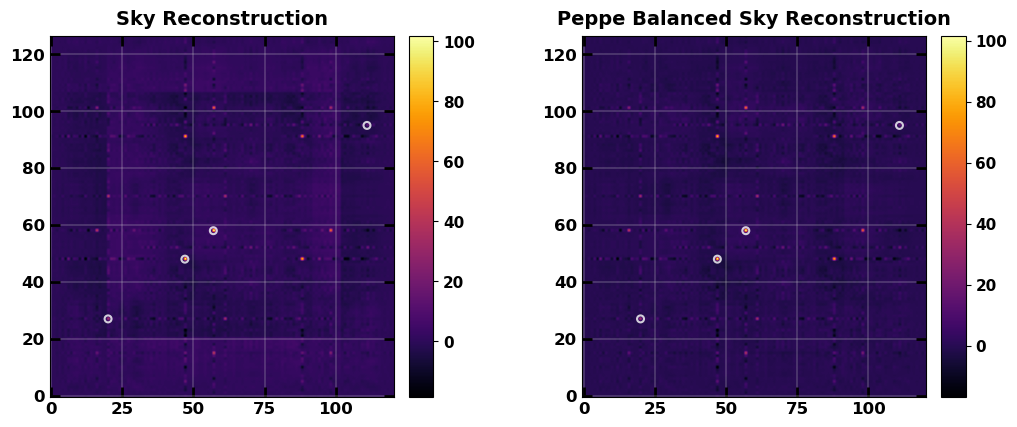

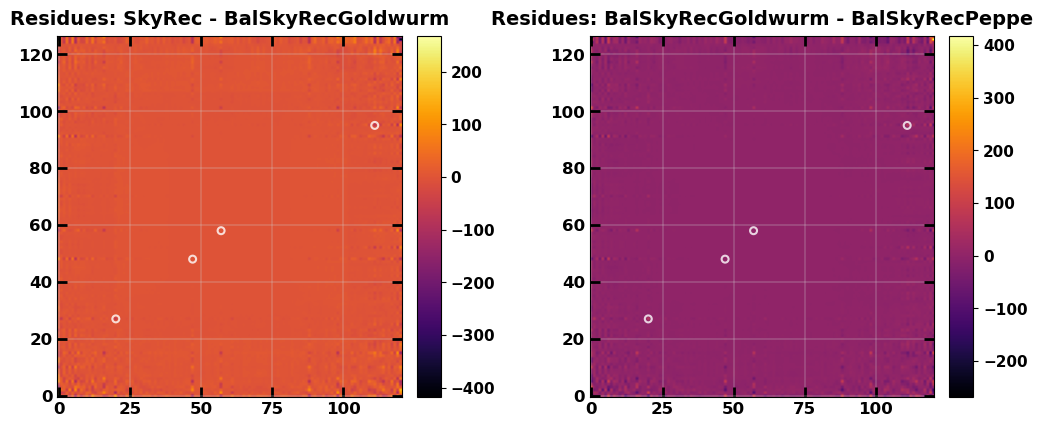

In [45]:
bal = SkyReconstructionBalancing(mask, decoder, bulk_array)
balanced_sky_goldwurm = bal.balanced_sky_reconstruction(fcfov_detector_image)

plot.image_plot([pcfov_sky_reconstruction, balanced_sky_goldwurm],
                ["Sky Reconstruction (w PCFOV)", "Goldwurm Balanced Sky Reconstruction (w PCFOV)"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[sources_pos, sources_pos])

plot.image_plot([pcfov_sky_reconstruction, balanced_sky_reconstruction],
                ["Sky Reconstruction", "Peppe Balanced Sky Reconstruction"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[sources_pos, sources_pos])

plot.image_plot([pcfov_sky_reconstruction - balanced_sky_goldwurm, balanced_sky_goldwurm - balanced_sky_reconstruction],
                ["Residues: SkyRec - BalSkyRecGoldwurm", "Residues: BalSkyRecGoldwurm - BalSkyRecPeppe"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[sources_pos, sources_pos])

- Let's decompose per counts the balanced reconstruction of the sky with the method from Goldwurm&Gros

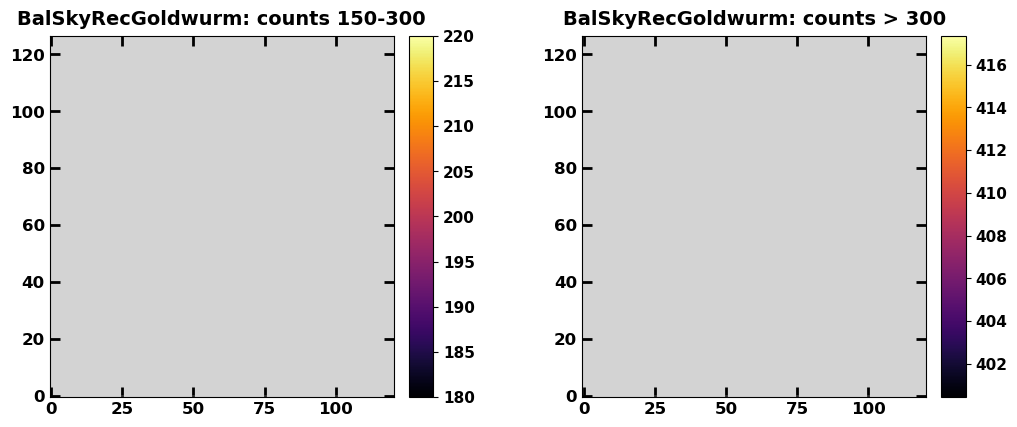

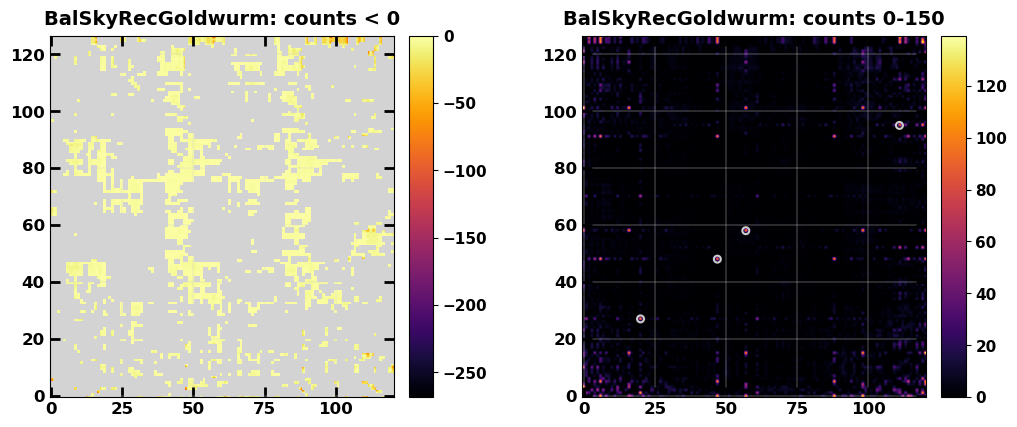

In [63]:
def _normalize(array):
    return (array - array.min())/(array.max() - array.min())

bsky300plus = balanced_sky_goldwurm.copy()
bsky300plus[balanced_sky_goldwurm < 300] = np.nan

bsky150300 = balanced_sky_goldwurm.copy()
bsky150300[balanced_sky_goldwurm < 150] = np.nan; bsky150300[balanced_sky_goldwurm > 300] = np.nan

bsky0150 = balanced_sky_goldwurm.copy()
bsky0150[balanced_sky_goldwurm < 0] = 0; bsky0150[balanced_sky_goldwurm > 150] = 0

bsky0minus = balanced_sky_goldwurm.copy()
bsky0minus[balanced_sky_goldwurm > 0] = np.nan


plot.image_plot([bsky150300, bsky300plus],
                ["BalSkyRecGoldwurm: counts 150-300", "BalSkyRecGoldwurm: counts > 300"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[None, None])

plot.image_plot([bsky0minus, bsky0150],
                ["BalSkyRecGoldwurm: counts < 0", "BalSkyRecGoldwurm: counts 0-150"],
                cbarcmap=["inferno", "inferno"],
                simulated_sources=[None, sources_pos])
